In [1]:
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
# Import metrics from scikit-learn
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Set random seed and device
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Define data transformations for CIFAR100
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
])

# Load CIFAR100 dataset
cifar100_full = torchvision.datasets.CIFAR100(root='./datasets', train=True, download=True, transform=transform_train)
train_size = int(0.9 * len(cifar100_full))
val_size = len(cifar100_full) - train_size
cifar100_train, cifar100_val = random_split(cifar100_full, [train_size, val_size])

cifar100_test = torchvision.datasets.CIFAR100(root='./datasets', train=False, download=True, transform=transform_test)

batch_size = 128
train_loader = DataLoader(cifar100_train, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(cifar100_val, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(cifar100_test, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# BasicBlock for ResNet-18
class BasicBlockRes18(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlockRes18, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_channels)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

# Definition of ResNet-18
class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.in_channels = 64
        # Modified initial conv for CIFAR (3x3 kernel)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu  = nn.ReLU(inplace=True)
        # Build layers with 2 blocks per layer
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc      = nn.Linear(512 * BasicBlockRes18.expansion, num_classes)
        
    def _make_layer(self, out_channels, blocks, stride):
        layers = []
        layers.append(BasicBlockRes18(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlockRes18(self.in_channels, out_channels, stride=1))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [4]:
# load model
model = ResNet18(num_classes=100).to(device)
print(model)

SimplifiedAlexNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=100, bias=True)
  )
)


In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)


def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)
    return running_loss / len(dataloader.dataset), correct / total


print("Selected AlexNet parameter count:", count_parameters(model))

Selected AlexNet parameter count: 643492


In [6]:
num_epochs = 30
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/30: Train Loss: 3.9146, Val Loss: 3.4178, Val Acc: 0.1852
Epoch 2/30: Train Loss: 3.2582, Val Loss: 3.0959, Val Acc: 0.2384
Epoch 3/30: Train Loss: 2.9540, Val Loss: 2.9072, Val Acc: 0.2734
Epoch 4/30: Train Loss: 2.7505, Val Loss: 2.6982, Val Acc: 0.3188
Epoch 5/30: Train Loss: 2.5905, Val Loss: 2.5761, Val Acc: 0.3382
Epoch 6/30: Train Loss: 2.4676, Val Loss: 2.5044, Val Acc: 0.3570
Epoch 7/30: Train Loss: 2.3656, Val Loss: 2.4207, Val Acc: 0.3742
Epoch 8/30: Train Loss: 2.2686, Val Loss: 2.3767, Val Acc: 0.3786
Epoch 9/30: Train Loss: 2.2136, Val Loss: 2.3452, Val Acc: 0.3898
Epoch 10/30: Train Loss: 2.1426, Val Loss: 2.3238, Val Acc: 0.3976
Epoch 11/30: Train Loss: 2.0857, Val Loss: 2.2483, Val Acc: 0.4142
Epoch 12/30: Train Loss: 2.0357, Val Loss: 2.2313, Val Acc: 0.4150
Epoch 13/30: Train Loss: 1.9822, Val Loss: 2.2848, Val Acc: 0.4168
Epoch 14/30: Train Loss: 1.9460, Val Loss: 2.2324, Val Acc: 0.4172
Epoch 15/30: Train Loss: 1.9115, Val Loss: 2.1744, Val Acc: 0.4386
Epoc

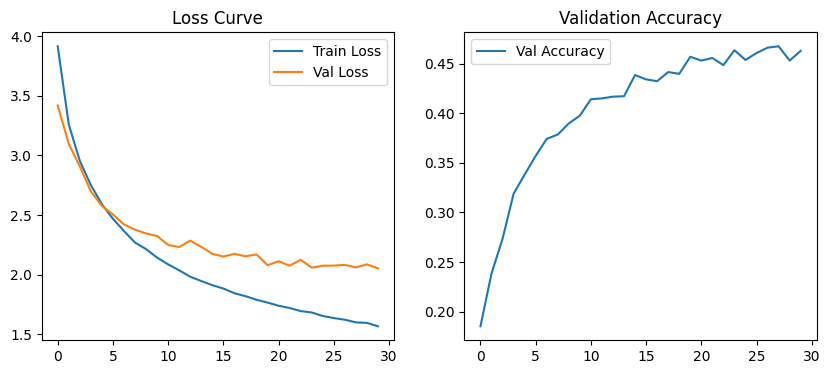

In [11]:
# Save training data and plot the curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy')
plt.legend()
plt.title("Validation Accuracy")
plt.savefig("./images/p3_100_ResNet18_results.png")
plt.show()

In [8]:
def compute_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    return np.array(all_preds), np.array(all_targets)

In [9]:
# Compute predictions on the test set
test_preds, test_targets = compute_metrics(model, test_loader)

# Calculate precision, recall, and F1 score (weighted average)
precision = precision_score(test_targets, test_preds, average="weighted")
recall = recall_score(test_targets, test_preds, average="weighted")
f1 = f1_score(test_targets, test_preds, average="weighted")
conf_matrix = confusion_matrix(test_targets, test_preds)
class_report = classification_report(test_targets, test_preds, target_names=cifar100_test.classes)

print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Test Precision: 0.5107441154585228
Test Recall: 0.5005
Test F1 Score: 0.49530132372294694

Confusion Matrix:
 [[62  0  1 ...  0  0  0]
 [ 0 57  0 ...  0  0  1]
 [ 1  0 39 ...  1  6  0]
 ...
 [ 0  0  0 ... 50  2  0]
 [ 0  1  8 ...  0 23  0]
 [ 0  0  2 ...  0  0 46]]

Classification Report:
                precision    recall  f1-score   support

        apple       0.83      0.62      0.71       100
aquarium_fish       0.69      0.57      0.62       100
         baby       0.35      0.39      0.37       100
         bear       0.31      0.23      0.26       100
       beaver       0.27      0.27      0.27       100
          bed       0.54      0.38      0.45       100
          bee       0.46      0.67      0.54       100
       beetle       0.55      0.52      0.53       100
      bicycle       0.74      0.53      0.62       100
       bottle       0.76      0.58      0.66       100
         bowl       0.39      0.30      0.34       100
          boy       0.31      0.32      0.32    

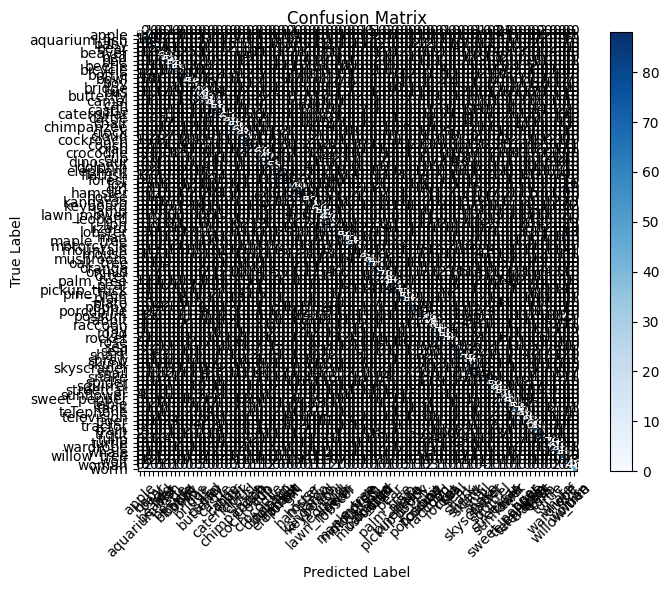

In [10]:
# Plot the confusion matrix with numeric annotations
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(cifar100_test.classes))
plt.xticks(tick_marks, cifar100_test.classes, rotation=45)
plt.yticks(tick_marks, cifar100_test.classes)

thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("./images/p3_100_ResNet18_matrix.png")
plt.show()